##

# integrated spleen dataset

# annotating HS cells via cell projection (to the reference cells)

In [1]:
%matplotlib widget

import warnings
warnings.filterwarnings('ignore')

import os, sys, math, re
import natsort, json, operator, getpass
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

import scanpy as sc
import scanpy.external as sce

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets

# to deal with those pesky non-persistent widget plots
import base64
from io import BytesIO
from IPython.display import HTML

In [2]:
with open('/.singularity.d/labels.json') as fh:
    singularity = json.load(fh)
    
singularity['Version']

'metztli.25j'

In [3]:
sc.settings.verbosity = 3             # show some output
sc.settings.file_format_figs = 'svg'  # set this to 'svg' (notebook) or 'pdf' (files) if you want vector graphics
sc.settings.savefigs = False

In [4]:
home = str(Path.home())
user = getpass.getuser()

In [5]:
"""
Allows to create a persistent png image from
the last plotted matplotlib plot widget
"""
def perma_plot():
    # TODO: maybe pass parameters for savefig
    #       to control quality/type of img
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    
    encoded_string = base64.b64encode(buffer.read()).decode('utf-8')
    html_string = '<img src=\'data:image/png;base64,{}\'>'.format(encoded_string)
    
    return html_string

---

In [6]:
basedir = os.path.join(home, 'databoard/users', user, '2021/BloodPaper/')

sc.settings.writedir = os.path.join(basedir, 'h5ad/')

---

## 2021-11-03

---

In [7]:
now = datetime.now()
prefix = now.strftime('%Y%m%d')
print(prefix)

20211103


In [8]:
import cellproject_master.cellproject as cp

In [9]:
integrated = sc.read('20211102_COMBO_SPLEEN_Seurat_VST_classic_integration_Scanpy_downstream_processed_basic')

---

### 2x SPL samples (SLX21128)

---

In [12]:
fetch1 = os.path.join(home, 'databoard/users', user, '2021/SLX21128/h5ad/')

target = sc.read( os.path.join(fetch1, '20211026_SLX21128_SPL_CD19neg_CD34pos_HVG_DR_leiden') )
target.shape

(9939, 22955)

Set target's X as the lognormed data

In [13]:
target.X = target.layers['lognorm'].copy()

In [14]:
target.obs['donor'] = target.obs.apply( lambda x: 'SPL_' + x.genotype, axis=1 )

Adjust ``target.obs.index`` so that it matches with ``integrated.obs.index``

In [28]:
target.obs.index = [x.replace('-', '.') for x in target.obs.index]

In [17]:
integrated

AnnData object with n_obs × n_vars = 32007 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor', 'library', 'leiden.1.2', 'annot'
    var: 'features', 'mean', 'std'
    uns: 'annot_colors', 'donor_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'seurat'
    obsp: 'connectivities', 'distances'

In [19]:
sc.pl.embedding(integrated, basis='umap', color='donor')
plt.subplots_adjust(right=.8)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


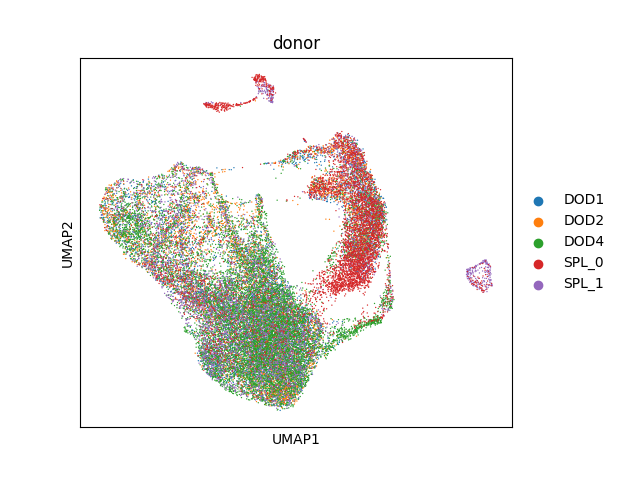

In [21]:
HTML(perma_plot())

In [34]:
#Splitting combined dataset
ref = integrated[integrated.obs.donor.isin(['DOD1', 'DOD2', 'DOD4']), :].copy()
target = integrated[~integrated.obs.donor.isin(['DOD1', 'DOD2', 'DOD4']), :].copy()

#### performing the cell projection and annotation transfer

In [40]:
%%time
#Transferring the 'annot' column
cp.project_cells(target, ref,
                       obs_columns=['annot'],
                       fit_pca=False,
                       scale_data=False)

No valid UMAP object provided, UMAP parameters left unmodified
CPU times: user 20.4 s, sys: 1.01 s, total: 21.4 s
Wall time: 21.5 s


In [41]:
target

AnnData object with n_obs × n_vars = 9939 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor', 'library', 'leiden.1.2', 'annot', 'take01_annot', 'ref_annot'
    var: 'features', 'mean', 'std'
    uns: 'annot_colors', 'donor_colors', 'neighbors', 'pca', 'umap', 'cross_nn', 'adj_score'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'seurat'
    obsp: 'connectivities', 'distances'

In [42]:
sc.pl.umap(target, color=['ref_annot'])

... storing 'ref_annot' as categorical


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [50]:
plt.subplots_adjust(right=0.8)

In [51]:
axes = plt.gcf().get_axes()

handles, labels = axes[-1].get_legend_handles_labels()
axes[-1].legend(handles, labels)

lgnd = axes[-1].legend(handles, labels, loc=7, scatterpoints=1, 
                       frameon=False, fontsize=8, 
                       bbox_to_anchor=(1.275, 0.5))


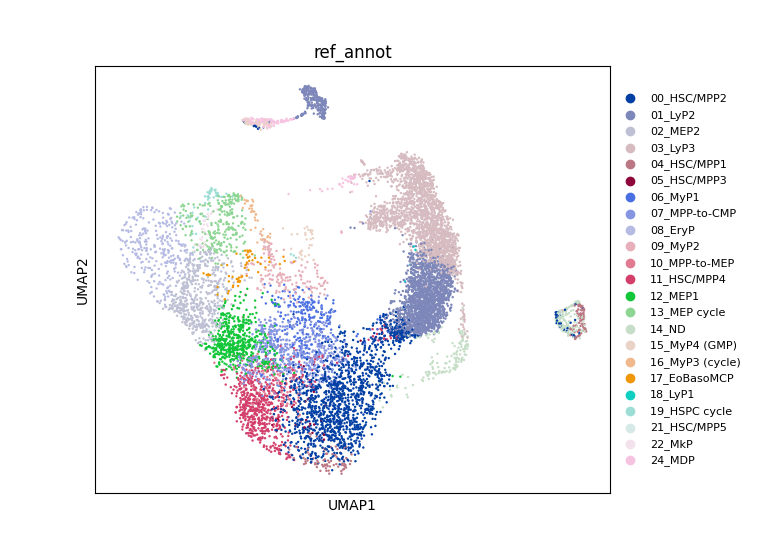

In [52]:
HTML(perma_plot())

In [53]:
%%time
sc.write(prefix+'_SLX21128_2x_SPL_COMBO_SPLEEN_integrated_cellproject_annotated_ERRATA', target)

CPU times: user 11 s, sys: 541 ms, total: 11.6 s
Wall time: 11.6 s


In [54]:
target.obs.groupby(['donor', 'ref_annot']).size().unstack()

ref_annot,00_HSC/MPP2,01_LyP2,02_MEP2,03_LyP3,04_HSC/MPP1,05_HSC/MPP3,06_MyP1,07_MPP-to-CMP,08_EryP,09_MyP2,...,13_MEP cycle,14_ND,15_MyP4 (GMP),16_MyP3 (cycle),17_EoBasoMCP,18_LyP1,19_HSPC cycle,21_HSC/MPP5,22_MkP,24_MDP
donor,,,,,,,,,,,,,,,,,,,,,
SPL_0,516,1690,179,1562,32,6,49,139,75,33,...,53,130,66,6,28,3,8,0,7,122
SPL_1,983,379,378,542,127,21,190,469,215,127,...,195,164,29,34,33,1,42,1,25,13


In [55]:
target.obs.groupby(['donor', 'ref_annot']).size().unstack().to_csv('output/'+prefix+'_SLX_21128_SPL_C10_annots_counts_per_donor_CORRECTED.txt', sep='\t')